# La migration des érables à sucre au Canada

Ce document est divisé en quatre sections: \
A. Lecture des données \
B. Création de la table de données de travail \
C. Visualisation interactive des données \
D. Réponses aux questions de recherche

In [176]:
import geopandas
import rasterio
from pathlib import Path
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib as mpl

from utils import read_raster, reproject_raster, compute_area, zonal_stats_for_value, register_rasters, zonal_stats_intersection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Définition des variables 

In [67]:
DATA_PATH = Path("data/")
CRS = "EPSG:4326"
TOP_N = 20

# A. Lecture des données 

### Données d'exploitations acéricoles et d'entailles d'érables

Les données d'exploitations et d'entailles proviennent de Statistique Canada. On a télécharché les données pour [2011, 2016](https://www150.statcan.gc.ca/t1/tbl1/fr/cv!recreate.action?pid=3210042301&selectedNodeIds=&checkedLevels=0D1,0D2,0D3,0D4,0D5,1D1&refPeriods=20110101,20160101&dimensionLayouts=layout3,layout3,layout2&vectorDisplay=false) et [2021](https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=3210036201), par région agricole de recensement (RAR). 

In [68]:
df_farms = pd.concat(
    [
        pd.read_csv(DATA_PATH / "fermes" / "3210036201_donneesselectionnees.csv", delimiter=";"), 
        pd.read_csv(DATA_PATH / "fermes" / "3210042301_donneesselectionnees.csv", delimiter=";")
    ]
).drop(
    [
        "UNITÉ DE MESURE", 
        "IDENTIFICATEUR D'UNITÉ DE MESURE", 
        "FACTEUR SCALAIRE", 
        "VECTEUR", 
        "COORDONNÉES", 
        "IDENTIFICATEUR SCALAIRE", 
        "STATUS", 
        "SYMBOLE", 
        "TERMINÉ", 
        "DÉCIMALES"
    ], 
    axis=1
).reset_index()

df_farms["GÉO"] = df_farms.apply(
    lambda row: row["GÉO"].split(" [")[0], 
    axis=1
)

df_farms["DGUID"] = df_farms.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)


df_farms = df_farms.replace(
    "Nombre d'exploitations déclarantes", 
    "num_exploitations"
).replace(
    "Nombre d'entailles", 
    "num_entailles"
).replace(
    "Nombre de fermes déclarantes", 
    "num_exploitations"
).pivot(
    index=["GÉO", "DGUID"], 
    columns=["PÉRIODE DE RÉFÉRENCE", "Entailles d'érables"], 
    values="VALEUR"
)

df_farms.columns = [f"{x}_{y}" for x, y in df_farms.columns.to_flat_index()]

df_farms.head()

,,2021_num_exploitations,2021_num_entailles,2011_num_exploitations,2016_num_exploitations,2011_num_entailles,2016_num_entailles
GÉO,DGUID,,,,,,
"Abitibi-Témiscamingue--Nord-du-Québec, Québec",S05012410,33.0,172146.0,28.0,22.0,148354.0,140771.0
"Bas-Saint-Laurent, Québec",S05012401,643.0,8097478.0,576.0,569.0,7095824.0,7527702.0
"Cariboo, Colombie-Britannique",S05015905,3.0,NaN,2.0,0.0,NaN,0.0
"Centre-du-Québec, Québec",S05012414,1049.0,4931211.0,837.0,889.0,3780767.0,3770134.0
"Chaudière-Appalaches, Québec",S05012412,3533.0,17936518.0,3177.0,3234.0,15912851.0,16223118.0


### Fichiers des limites géographiques

On téléchargement également les fichiers des [limites géographiques des régions agricoles de recensement (RAR)](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index2021-fra.cfm?year=21) à partir du site de Statistique Canada. 

In [69]:
df_boundaries = geopandas.read_file(
    DATA_PATH / "boundaries" / "lcar000b21a_e.shp"
).to_crs(
    CRS
).drop(
    ["CARUID", "CARENAME", "LANDAREA"], 
    axis=1
).rename(
    columns={"CARFNAME": "area_name"}
)

df_boundaries["DGUID"] = df_boundaries.apply(
    lambda row: row["DGUID"][4:], 
    axis=1
)

df_boundaries["total_area"] = compute_area(df_boundaries)

df_boundaries.head()

,DGUID,area_name,PRUID,geometry,total_area
0,S05011001,Région agricole de recensement 1,10,"MULTIPOLYGON (((-54.22551 47.52866, -54.22567 ...",16563.476030
1,S05011002,Région agricole de recensement 2,10,"MULTIPOLYGON (((-53.77539 48.71901, -53.77552 ...",60820.508340
2,S05011003,Région agricole de recensement 3,10,"MULTIPOLYGON (((-58.32368 49.25135, -58.32372 ...",329355.232998
3,S05011101,Région agricole de recensement 1,11,"MULTIPOLYGON (((-62.08769 46.39503, -62.08794 ...",1704.354313
4,S05011102,Région agricole de recensement 2,11,"MULTIPOLYGON (((-62.97843 46.29946, -62.97855 ...",2010.994061


On visualise les limites géographiques.

<AxesSubplot: >

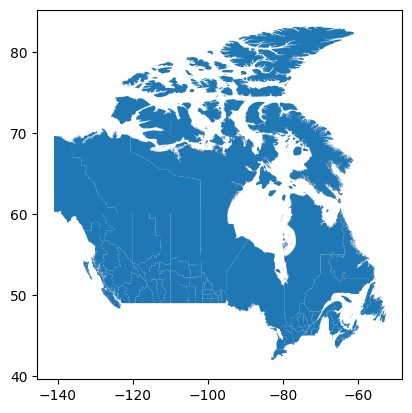

In [70]:
df_boundaries.plot()

### Carte de la biomasse (2001)

On télécharge ensuite les cartes de la biomasse aérienne de l'érable à sucre en tonnes/ha. Il s'agit d'un fichier de type raster avec une résolution de 250m. 

_Source: Beaudoin, A., Bernier, P. Y., Guindon, L., Villemaire, P., Guo, X. J., Stinson, G., . . . Hall, R. J. (2014). Mapping attributes of Canada’s forests at moderate resolution through kNN and MODIS imagery. Canadian journal of forest research, 44(5), 521-532. [doi:10.1139/cjfr-2013-0401](doi:10.1139/cjfr-2013-0401)_

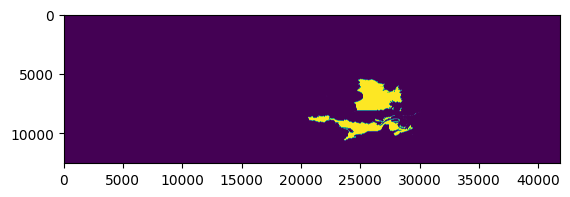

In [87]:
filename = DATA_PATH / "cartography" / "ACESAC_volume_250m_final-100.tif"    
biomass_raster = read_raster(filename, crs=CRS)
    
biomass_raster_data = biomass_raster.read(1)
plt.imshow(biomass_raster_data)
plt.show()

On calcule la biomasse totale (`total_biomass`) pour chacune des régions agricoles de recensement. 

In [91]:
df_boundaries["stats"] = zonal_stats(
    vectors=df_boundaries['geometry'], 
    raster=biomass_raster_data, 
    affine=biomass_raster.transform, 
    nodata=biomass_raster.nodata, 
    stats="sum"
)

df_boundaries["total_biomass"] = df_boundaries.apply(
    lambda row: row["stats"]["sum"], 
    axis=1
)

df_boundaries = df_boundaries.drop(["stats"], axis=1)

df_boundaries.head()

,DGUID,area_name,PRUID,geometry,total_area,total_biomass
0,S05011001,Région agricole de recensement 1,10,"MULTIPOLYGON (((-54.22551 47.52866, -54.22567 ...",16563.476030,NaN
1,S05011002,Région agricole de recensement 2,10,"MULTIPOLYGON (((-53.77539 48.71901, -53.77552 ...",60820.508340,NaN
2,S05011003,Région agricole de recensement 3,10,"MULTIPOLYGON (((-58.32368 49.25135, -58.32372 ...",329355.232998,0.000000
3,S05011101,Région agricole de recensement 1,11,"MULTIPOLYGON (((-62.08769 46.39503, -62.08794 ...",1704.354313,9719.747070
4,S05011102,Région agricole de recensement 2,11,"MULTIPOLYGON (((-62.97843 46.29946, -62.97855 ...",2010.994061,12076.436523


### Projections de l'enveloppe climatique propice à l'érable à sucre 

On télécharge ensuite les fichiers de projections climatiques pour l'érable à sucre (selon le scénario SDM ANUCLIM et le RCP 8.5) pour les horizons 2011-2040, 2041-2070 et 2071 à 2100. 

On considère une enveloppe "marginale" et une enveloppe "core", selon les définitions suivantes:
- "marginale": enveloppe climatique pour une période définie calibrée selon le min/max des conditions climatiques observées durant la période de référence.
- "core": Enveloppe climatique selon le 5e à 95e centile des conditions climatiques observées durant la période de référence 

_Source: https://protect-eu.mimecast.com/s/G3lTCVNkkFqzB6DHGqvem?domain=planthardiness.gc.ca ET McKENNEY, D. W., Pedlar, J. H., Rood, R. B., & Price, D. (2011). Revisiting projected shifts in the climate envelopes of North American trees using updated general circulation models. Global Change Biology, 17(8), 2720-2730._

#### Projection 2011-2040

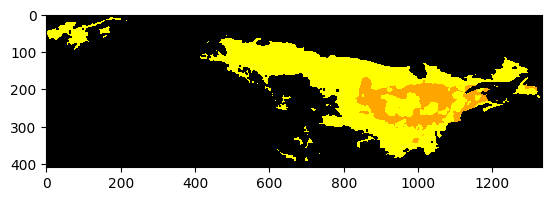

In [165]:
filename = DATA_PATH / "rasters" / "arcp8510000532011-2040.asc"

raster_2011_2040 = read_raster(filename, crs=CRS)
    
cmap = mpl.colors.ListedColormap(['black', 'yellow', 'orange'])
bounds = [no_data_value, 1, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

raster_2011_2040_data = raster_2011_2040.read(1)
plt.imshow(raster_2011_2040_data, cmap=cmap, norm=norm)
plt.show()

Pour chacune des régions agricoles de recensement, on calcule le nombre de pixel pour chacune des catégories ("marginale", "core" et "autres").

In [94]:
period = "2011-2040"

for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (no_data_value, "rest")
]:
    df_boundaries[f"{name}_{period}"] = zonal_stats_for_value(
        raster=raster_2011_2040, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

#### Projection 2041-2070

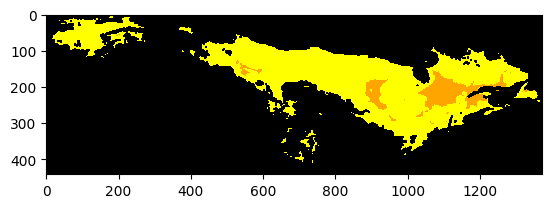

In [164]:
filename = DATA_PATH / "rasters" / "arcp8510000532041-2070.asc"

raster_2041_2070 = read_raster(filename, crs=CRS)

raster_2041_2070_data = raster_2041_2070.read(1)
plt.imshow(raster_2041_2070_data, cmap=cmap, norm=norm)
plt.show()

Pour chacune des régions agricoles de recensement, on calcule le nombre de pixel pour chacune des catégories ("marginale", "core" et "autres").

In [96]:
period = "2041-2070"

for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (no_data_value, "rest")
]:
    df_boundaries[f"{name}_{period}"] = zonal_stats_for_value(
        raster=raster_2041_2070, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

#### Projection 2071-2100

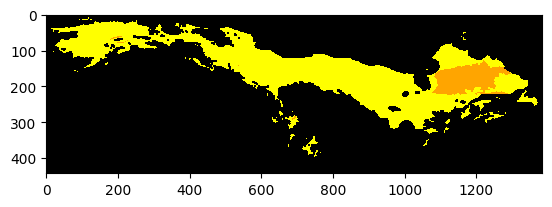

In [163]:
filename = DATA_PATH / "rasters" / "arcp8510000532071-2100.asc"
raster_2071_2100 = read_raster(filename, crs=CRS)

raster_2071_2100_data = raster_2071_2100.read(1)
plt.imshow(raster_2071_2100_data, cmap=cmap, norm=norm)
plt.show()

Pour chacune des régions agricoles de recensement, on calcule le nombre de pixel pour chacune des catégories ("marginale", "core" et "autres").

In [98]:
period = "2071-2100"

for value, name in [
    (1, "marginal"), 
    (3, "core"), 
    (no_data_value, "rest")
]:
    df_boundaries[f"{name}_{period}"] = zonal_stats_for_value(
        raster=raster_2071_2100, 
        vectors=df_boundaries["geometry"], 
        value=value, 
        data_value=100, 
        stats="count", 
        resolution=2.5
    )

### Intersection des projections

Pour chacune des régions, on observe la proportion qui demeure intacte d'une période à une autre. 

In [179]:
rasters, transform = register_rasters(
    raster_2011_2040, 
    raster_2041_2070, 
    raster_2071_2100
)
resgistered_raster_2011_2040, registered_raster_2041_2070, registered_raster_2071_2100 = rasters


df_boundaries[f"marginal_2011_and_2041"] = zonal_stats_intersection(
    df_boundaries['geometry'], 
    resgistered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999
)
df_boundaries[f"core_2011_and_2041"] = zonal_stats_intersection(
    df_boundaries['geometry'], 
    resgistered_raster_2011_2040, 
    registered_raster_2041_2070, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999
)
df_boundaries[f"marginal_2011_and_2071"] = zonal_stats_intersection(
    df_boundaries['geometry'], 
    resgistered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[1, 3], 
    nodata_value=-999
)
df_boundaries[f"core_2011_and_2071"] = zonal_stats_intersection(
    df_boundaries['geometry'], 
    resgistered_raster_2011_2040, 
    registered_raster_2071_2100, 
    affine=transform, 
    data_values=[3], 
    nodata_value=-999
)

# B. Création de la table de données de travail

On joint les données téléchargées dans un dataframe comprenant toutes les informations requises pour répondre aux questions de recherche. On calcule quelques statistiques préalables et on nettoie la table de données finale.

In [99]:
df = pd.merge(
    df_boundaries, 
    df_farms, 
    on="DGUID"
)

pr_df = pd.DataFrame({
    "PRUID": ["10", "11", "12", "13", "24", "35", "46", "47", "48", "59", "60", "61", "62"], 
    "province": [
        "Terre-Neuve-et-Labrador", 
        "Île-du-Prince-Édouard", 
        "Nouvelle-Écosse",
        "Nouveau-Brunswick",
        "Québec",
        "Ontario",
        "Manitoba",
        "Saskatchewan",
        "Alberta",
        "Colombie-Britannique",
        "Yukon",
        "Territoires du Nord-Ouest",
        "Nunavut"
    ]
}
)

df = df.merge(
    pr_df, 
    on="PRUID"
).drop("PRUID", axis=1)

df["rank_biomass"] = df["total_biomass"].rank(method="min", na_option="bottom", ascending=False)
df["rank_entailles"] = df["2021_num_entailles"].rank(method="min", na_option="bottom", ascending=False)
df["rank_exploitations"] = df["2021_num_exploitations"].rank(method="min", na_option="bottom", ascending=False)

df = df.rename({
    "all_2011-2040": "rest_2011-2040", 
    "all_2041-2070": "rest_2041-2070", 
    "all_2071-2100": "rest_2071-2100", 
}, axis=1)

df.head()

,DGUID,area_name,geometry,total_area,total_biomass,marginal_2011-2040,core_2011-2040,rest_2011-2040,marginal_2041-2070,core_2041-2070,...,2021_num_exploitations,2021_num_entailles,2011_num_exploitations,2016_num_exploitations,2011_num_entailles,2016_num_entailles,province,rank_biomass,rank_entailles,rank_exploitations
0,S05011001,Région agricole de recensement 1,"MULTIPOLYGON (((-54.22551 47.52866, -54.22567 ...",16563.476030,NaN,1762.50,0.00,12.50,1762.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,Terre-Neuve-et-Labrador,34.0,27.0,55.0
1,S05011002,Région agricole de recensement 2,"MULTIPOLYGON (((-53.77539 48.71901, -53.77552 ...",60820.508340,NaN,3693.75,2987.50,0.00,4862.50,1787.50,...,0.0,0.0,1.0,0.0,NaN,0.0,Terre-Neuve-et-Labrador,34.0,27.0,55.0
2,S05011003,Région agricole de recensement 3,"MULTIPOLYGON (((-58.32368 49.25135, -58.32372 ...",329355.232998,0.000000,20806.25,706.25,19193.75,33506.25,4293.75,...,0.0,0.0,0.0,0.0,0.0,0.0,Terre-Neuve-et-Labrador,32.0,27.0,55.0
3,S05011101,Région agricole de recensement 1,"MULTIPOLYGON (((-62.08769 46.39503, -62.08794 ...",1704.354313,9719.747070,0.00,162.50,0.00,106.25,56.25,...,1.0,NaN,3.0,5.0,458.0,NaN,Île-du-Prince-Édouard,30.0,42.0,52.0
4,S05011102,Région agricole de recensement 2,"MULTIPOLYGON (((-62.97843 46.29946, -62.97855 ...",2010.994061,12076.436523,0.00,212.50,0.00,206.25,6.25,...,8.0,9464.0,6.0,8.0,NaN,NaN,Île-du-Prince-Édouard,29.0,22.0,30.0


# C. Visualisation interactive des données 

On peut visualiser les différentes variables disponibles dans cette carte interactive. 

Attention! Comme il s'agit de données relativement lourdes, on enregistre un délai entre le changement de variable et le rafraichissement de la carte interactive. 

In [100]:
def _plot(province, column_name):
    return df[df["province"] == province].explore(column_name)
    
interact(
    _plot,
    province= df["province"].unique(),
    column_name=df.columns.tolist()[3:-2]
)

interactive(children=(Dropdown(description='province', options=('Terre-Neuve-et-Labrador', 'Île-du-Prince-Édou…

<function __main__._plot(province, column_name)>

# D. Réponses aux questions de recherche

Pour répondre aux questions de recherche, on définie deux scénarios: 
- Scénario A: On ne considère que les zones avec les conditions climatiques cores.
- Scénario B: On considère les zones avec les conditions climatiques cores et marginales.

On décline également la réponse par rapport aux projections de 2041-2070, puis aux projections de 2071-2100. 

On s'attend à ce que les différences les plus marquées soient observées selon le scénario A, avec les projections de 2071-2100, et les différences les moins marquées avec le scénario B et les projections de 2041-2070. 

Les conclusions aux questions de recherche sont affichées <span style="color:red"> en rouge </span>.

## 1. Où se situent les zones propices au développement de l’érable à sucre au Canada et comment seront-elles affectées par le réchauffement climatique?

### Y a-t-il des zones actuellement propices qui ne le seront plus du tout?

On calcule la perte de zone propice pour les scénarios A et B, ainsi que pour les deux préiodes de projections. 

In [101]:
# Scénario A 
df["diff_A_2011_vs_2041"] = df["core_2011-2040"] - df["core_2041-2070"]
df["diff_A_2011_vs_2071"] = df["core_2011-2040"] - df["core_2071-2100"]

# Scénario B
df["core_marginal_2011-2040"] = df["core_2011-2040"] + df["marginal_2011-2040"]
df["core_marginal_2041-2070"] = df["core_2041-2070"] + df["marginal_2041-2070"]
df["core_marginal_2071-2100"] = df["core_2071-2100"] + df["marginal_2071-2100"]
df["diff_B_2011_vs_2041"] = df["core_marginal_2011-2040"] - df["core_marginal_2041-2070"]
df["diff_B_2011_vs_2071"] = df["core_marginal_2011-2040"] - df["core_marginal_2071-2100"]

#### Scénario A (2011-2040 vs 2041-2070)

On affiche les données ordonnées en fonction des pertes de zones propices (`diff_A_2011_vs_2041`). `core_2011-2040` et `core_2041-2070` représentent l'aire total (en kilomètre carré) à l'intérieur des zones propices, et `rank_biomass` représente le rang de la région agricole de recensement en fonction de la biomasse totale d'érable à sucre. 

À noter qu'on considère la biomasse totale, indépendemment de l'aire totale d'une région de recensement. 

<span style="color:red"> 
On constate que les régions du Nord, du Sud et de l'Est de l'Ontario sont les régions où on enregistre les plus importantes pertes de territoires. Malgré tout, les projections de 2041-2070 indiquent qu'une grande partie de ces régions seront encore propices au développement de l'érable à sucre (19750km carré pour le Nord, 669km carré pour le Sud et 294km carré pour l'Est)). Il en va de même pour la Région agricole de recensement 2 de Terre-Neuve-et-Labrador où 1788km carré sont toujours propices au développement.
    
À l'inverse, les Région agricole de recensement 2 et 3 du Nouveau-Brunswick, ainsi que la Montérégie (Québec) enregistre également d'importantes pertes, et on constate que ces régions ne seront plus propices au développement de l'érable à sucre en 2041 (moins de 56km carré de zones proopices). 
    
De même, ls Région agricole de recensement 3 de Nouvelle-Écosse ainsi que les Régions agricole de recensement 2 et 3 de l'Île-du-Prince-Édouard sont actuellement propices, mais ne sont plus du tout en 2041. 
</span>

In [102]:
df.sort_values(
    "diff_A_2011_vs_2041", 
    ascending=False
)[[
    "area_name", 
    "province", 
    "diff_A_2011_vs_2041", 
    "core_2011-2040",
    "core_2041-2070", 
    "rank_biomass"
]].reset_index().head(n=TOP_N)

,index,area_name,province,diff_A_2011_vs_2041,core_2011-2040,core_2041-2070,rank_biomass
0,33,Région du Nord de l'Ontario,Ontario,8112.50,27862.50,19750.00,1.0
1,29,Région du Sud de l'Ontario,Ontario,1306.25,1975.00,668.75,15.0
2,32,Région de l'Est de l'Ontario,Ontario,1281.25,1575.00,293.75,5.0
3,1,Région agricole de recensement 2,Terre-Neuve-et-Labrador,1200.00,2987.50,1787.50,34.0
4,12,Région agricole de recensement 2,Nouveau-Brunswick,1031.25,1056.25,25.00,24.0
5,27,Montérégie,Québec,1000.00,1056.25,56.25,18.0
6,13,Région agricole de recensement 3,Nouveau-Brunswick,806.25,850.00,43.75,27.0
7,25,Gaspésie--Îles-de-la-Madeleine,Québec,675.00,2187.50,1512.50,21.0
8,31,Région du Centre de l'Ontario,Ontario,600.00,2487.50,1887.50,2.0
9,14,Région agricole de recensement 4,Nouveau-Brunswick,556.25,2718.75,2162.50,14.0


#### Scénario A (2011-2040 vs 2071-2100)

On affiche les données ordonnées en fonction des pertes de zones propices (`diff_A_2011_vs_2071`). `core_2011-2040` et `core_2071-2070` représentent l'aire total (en kilomètre carré) à l'intérieur des zones propices, et `rank_biomass` représente le rang de la région agricole de recensement en fonction de la biomasse totale d'érable à sucre. 

<span style="color:red"> 
Les conclusions sont d'autant plus imposantes en 2071. Presque toutes les régions enregistrant une perte ne seront plus propices en 2071. On note quelques exceptions, notament la Mauricie (Québec) et de la Région agricole de recensement 2 de Terre-Neuve-et-Labrabor,  ou une faible partie du territoire demeure propice au développement de l'érable à sucre (187km carré pour la Mauricie et 337km carré pour la Région agricole de recensement 2 de TNL). 
</span>

In [103]:
df.sort_values(
    "diff_A_2011_vs_2071", 
    ascending=False
).reset_index()[[
    "area_name",  
    "province",
    "diff_A_2011_vs_2071", 
    "core_2011-2040",
    "core_2071-2100",
    "rank_biomass"
]].head(n=TOP_N)

,area_name,province,diff_A_2011_vs_2071,core_2011-2040,core_2071-2100,rank_biomass
0,Région du Nord de l'Ontario,Ontario,27850.00,27862.50,12.50,1.0
1,Mauricie,Québec,3962.50,4150.00,187.50,12.0
2,Outaouais,Québec,3550.00,3550.00,0.00,3.0
3,Région agricole de recensement 4,Nouveau-Brunswick,2718.75,2718.75,0.00,14.0
4,Région agricole de recensement 2,Terre-Neuve-et-Labrador,2650.00,2987.50,337.50,34.0
5,Région de l'Ouest de l'Ontario,Ontario,2506.25,2506.25,0.00,13.0
6,Région du Centre de l'Ontario,Ontario,2487.50,2487.50,0.00,2.0
7,Bas-Saint-Laurent,Québec,2443.75,2443.75,0.00,8.0
8,Laurentides,Québec,2387.50,2393.75,6.25,4.0
9,Gaspésie--Îles-de-la-Madeleine,Québec,2187.50,2187.50,0.00,21.0


#### Scénario B (2011-2040 vs 2041-2070)

On affiche les données ordonnées en fonction des pertes de zones propices (`diff_B_2011_vs_2041`). `core_marginal_2011-2040` et `core_marginal_2041-2070` représentent l'aire total (en kilomètre carré) à l'intérieur des zones propices, et `rank_biomass` représente le rang de la région agricole de recensement en fonction de la biomasse totale d'érable à sucre. 

<span style="color:red"> 
Lorsqu'on considère les conditions climatiques cores et marginales, on enregistre très peu de recul en 2041. La Région agricole de recensement 6 d'Alberta enregistre un recul important, mais conserve malgré tout une part importante de territoire propice au développement. L'érable à sucre n'est toutefois pas présent dans cette région. Il en va de même pour Vancouver Island-Coast et Lower Mainland-Southwest en C.-B.
</span>

In [104]:
df.sort_values(
    "diff_B_2011_vs_2041", 
    ascending=False
).reset_index()[[
    "area_name",  
    "province",
    "diff_B_2011_vs_2041", 
    "core_marginal_2011-2040", 
    "core_marginal_2041-2070",
    "rank_biomass"
]].head(n=TOP_N)

,area_name,province,diff_B_2011_vs_2041,core_marginal_2011-2040,core_marginal_2041-2070,rank_biomass
0,Région agricole de recensement 6,Alberta,1900.00,22700.00,20800.00,34.0
1,Vancouver Island-Coast,Colombie-Britannique,556.25,793.75,237.50,34.0
2,Lower Mainland-Southwest,Colombie-Britannique,93.75,93.75,0.00,34.0
3,Région agricole de recensement 5,Nouvelle-Écosse,62.50,1106.25,1043.75,17.0
4,Région agricole de recensement 1,Saskatchewan,50.00,6781.25,6731.25,34.0
5,Région agricole de recensement 2,Saskatchewan,43.75,3056.25,3012.50,34.0
6,Région agricole de recensement 2,Terre-Neuve-et-Labrador,31.25,6681.25,6650.00,34.0
7,Région agricole de recensement 1,Terre-Neuve-et-Labrador,0.00,1762.50,1762.50,34.0
8,Région agricole de recensement 6,Manitoba,0.00,1681.25,1681.25,34.0
9,Région de l'Ouest de l'Ontario,Ontario,0.00,2762.50,2762.50,13.0


#### Scénario B (2011-2040 vs 2071-2100)

On affiche les données ordonnées en fonction des pertes de zones propices (`diff_B_2011_vs_2041`). `core_marginal_2011-2040` et `core_marginal_2071-2100` représentent l'aire total (en kilomètre carré) à l'intérieur des zones propices, et `rank_biomass` représente le rang de la région agricole de recensement en fonction de la biomasse totale d'érable à sucre. 

<span style="color:red"> 
En 2071, on constate qu'une très faible portion de certaines régions seront propice au développement de l'érable à sucre. C'est le cas entre autres de la Montérégie au Québec (18km carré de territoire propice), des Régions agricole de recensement 1 et 2 du Manitoba (moins de 150km carré) et Vancouver Island-Coast en Colombie-Britannique. 
    
À noter que si ces régions sont considérés comme ayant des conditions climatiques propices, l'érable à sucre n'est actuellement présent qu'en Montérégie. 
</span>

In [105]:
df.sort_values(
    "diff_B_2011_vs_2071", 
    ascending=False
).reset_index()[[
    "area_name",  
    "province",
    "diff_B_2011_vs_2071", 
    "core_marginal_2011-2040", 
    "core_marginal_2071-2100",
    "rank_biomass"
]].head(n=TOP_N)

,area_name,province,diff_B_2011_vs_2071,core_marginal_2011-2040,core_marginal_2071-2100,rank_biomass
0,Région agricole de recensement 1,Saskatchewan,3400.00,6781.25,3381.25,34.0
1,Région agricole de recensement 4,Saskatchewan,3093.75,3956.25,862.50,34.0
2,Cariboo,Colombie-Britannique,3006.25,9306.25,6300.00,34.0
3,Région agricole de recensement 2,Saskatchewan,2900.00,3056.25,156.25,34.0
4,Région de l'Est de l'Ontario,Ontario,2718.75,3137.50,418.75,5.0
5,Région agricole de recensement 2,Terre-Neuve-et-Labrador,1968.75,6681.25,4712.50,34.0
6,Région agricole de recensement 6,Alberta,1612.50,22700.00,21087.50,34.0
7,Thompson-Okanagan,Colombie-Britannique,1231.25,4868.75,3637.50,34.0
8,Montérégie,Québec,1131.25,1150.00,18.75,18.0
9,Région agricole de recensement 2,Manitoba,1068.75,1112.50,43.75,34.0


### Quelle proportion du Canada et des provinces est actuellement propice au développement de l’érable à sucre? Qu'elle deviendra cette proportion avec le réchauffement climatique?

#### Canada 

On calcule la proportion du Canada qui est propice au développement de l'érable à sucre en 2011, 2041 et 2071, selon les scénarios A et B. 

<span style="color:red"> 
On constate que la proportion du territoire canadien propice au développement de l'érable à sucre s'accroit avec le temps, qu'on se fit au scénario A ou B. En effet, l'enveloppe climatique ne rétrécit pas, mais elle se déplace vers le Nord. 
</span>

In [106]:
sum_A_2011 = df['core_2011-2040'].sum() / (df['rest_2011-2040'].sum() + df['core_marginal_2011-2040'].sum())
sum_B_2011 = df['core_marginal_2011-2040'].sum() / (df['rest_2011-2040'].sum() + df['core_marginal_2011-2040'].sum())

sum_A_2041 = df['core_2041-2070'].sum() / (df['rest_2041-2070'].sum() + df['core_marginal_2041-2070'].sum())
sum_B_2041 = df['core_marginal_2041-2070'].sum() / (df['rest_2041-2070'].sum() + df['core_marginal_2041-2070'].sum())

sum_A_2071 = df['core_2071-2100'].sum() / (df['rest_2071-2100'].sum() + df['core_marginal_2071-2100'].sum())
sum_B_2071 = df['core_marginal_2071-2100'].sum() / (df['rest_2071-2100'].sum() + df['core_marginal_2071-2100'].sum())

print(f"Scénario A: {round(sum_A_2011, 3)} (2011), {round(sum_A_2041, 3)} (2041), {round(sum_A_2071, 3)} (2071)")
print(f"Scénario B: {round(sum_B_2011, 3)} (2011), {round(sum_B_2041, 3)} (2041), {round(sum_B_2071, 3)} (2071)")

Scénario A: 0.122 (2011), 0.162 (2041), 0.142 (2071)
Scénario B: 0.641 (2011), 0.839 (2041), 0.814 (2071)


#### Provinces

On calcule ensuite ces mêmes proportions à l'échelle des provinces. `sum_X_YYYY` représente la proportion pour l'année de départ d'une projection donnée (`YYYY`) et un scénario (`X`).

<span style="color:red"> 
On observe un recul important de la proportion des zones propices dans les provinces du Nouveau-Brunswick, de l'Ontario et de l'Île-du-Prince-Édouard. En 2071, l'entièreté de ces trois provinces ne sera pas propice au développement de l'érable à sucre (selon le scénario A). La proportion de zones propices demeure plus stable dans le temps considérant le scénario B. 

Au Québec, une plus grande portion de la province serait propice au développement de l'arbre à sucre avec le temps, tant selon le scénario A que le scénario B. Il en va de même pour Terre-Neure-et-Labrador, province qui n'est présentement pas très propice au développement de l'érable à sucre. 
</span>

In [107]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["sum_A_2011"] = df_pr['core_2011-2040'] / (df_pr['rest_2011-2040'] + df_pr['core_marginal_2011-2040'])
df_pr["sum_B_2011"] = df_pr['core_marginal_2011-2040'] / (df_pr['rest_2011-2040'] + df_pr['core_marginal_2011-2040'])

df_pr["sum_A_2041"] = df_pr['core_2041-2070'] / (df_pr['rest_2041-2070'] + df_pr['core_marginal_2041-2070'])
df_pr["sum_B_2041"] = df_pr['core_marginal_2041-2070'] / (df_pr['rest_2041-2070'] + df_pr['core_marginal_2041-2070'])

df_pr["sum_A_2071"] = df_pr['core_2071-2100'] / (df_pr['rest_2071-2100'] + df_pr['core_marginal_2071-2100'])
df_pr["sum_B_2071"] = df_pr['core_marginal_2071-2100'] / (df_pr['rest_2071-2100'] + df_pr['core_marginal_2071-2100'])

df_pr[[
    "sum_A_2011", 
    "sum_A_2041", 
    "sum_A_2071", 
    "sum_B_2011", 
    "sum_B_2041", 
    "sum_B_2071", 
]]

/var/folders/50/kj5b053d1d356s85b448rw4c0000gn/T/ipykernel_38038/4169222555.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pr = df.groupby(


,sum_A_2011,sum_A_2041,sum_A_2071,sum_B_2011,sum_B_2041,sum_B_2071
province,,,,,,
Alberta,0.000000,0.057331,0.008279,0.824234,0.897396,0.831313
Colombie-Britannique,0.006316,0.075851,0.026880,0.500809,0.628419,0.511767
Manitoba,0.000000,0.000000,0.000000,0.578708,0.823248,0.806491
Nouveau-Brunswick,0.845151,0.466178,0.000000,1.000000,1.000000,0.666667
Nouvelle-Écosse,0.065862,0.000000,0.000000,0.998902,0.987925,0.893524
Ontario,0.324458,0.219920,0.000111,0.890269,0.999889,0.957834
Québec,0.220767,0.377505,0.441704,0.489674,0.824652,0.951451
Saskatchewan,0.000000,0.000000,0.000000,0.675455,0.823552,0.669769
Terre-Neuve-et-Labrador,0.075133,0.123697,0.371218,0.609331,0.939995,0.934528


## 2. Où se concentre la production de sirop d’érable au Canada. Et comment a-t-elle évolué au fil des années?

### Où se concentre la production de sirop d’érable au Canada?

#### Proportions par région agricole de recensement

On affiche les données ordonnées en fonction du nombre d'entailles en 2021 (`2021_num_entailles`). On affiche également le nombre d'exploitations en 2021 (`2021_num_exploitations`), et le rang de la région agricole de recensement en fonction de la biomasse totale	(`rank_biomass`), du nombre d'entailles (`rank_entailles`) et du nombre d'exploitations acéricoles (`rank_exploitations`).

<span style="color:red"> 
Le Québec domine l'exploitation des érables à sucre. On retrouve également une importante production au Nouveau-Brunswick, en Ontario et, dans une moindre mesure, en Nouvelle-Écosse. 32% des entailles sont dans la région de Chaudière-Appalache, 15% en Estrie et 15% au Bas-Saint-Laurent.
</span>

In [108]:
num_entailles_2021 = df["2021_num_entailles"].sum()
num_entailles_2016 = df["2016_num_entailles"].sum()
num_entailles_2011 = df["2011_num_entailles"].sum()

num_exploitations_2021 = df["2021_num_exploitations"].sum()
num_exploitations_2016 = df["2016_num_exploitations"].sum()
num_exploitations_2011 = df["2011_num_exploitations"].sum()

df["2021_percent_entailles"] = df["2021_num_entailles"] / num_entailles_2021
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

df.sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_percent_entailles", 
    "2021_num_exploitations", 
    "2021_percent_exploitations", 
    "rank_biomass", 
    "rank_entailles",
    "rank_exploitations"
]].head(n=TOP_N)

,area_name,province,2021_num_entailles,2021_percent_entailles,2021_num_exploitations,2021_percent_exploitations,rank_biomass,rank_entailles,rank_exploitations
0,Chaudière-Appalaches,Québec,17936518.0,0.329818,3533.0,0.306126,9.0,1.0,1.0
1,Estrie,Québec,8386438.0,0.154211,1185.0,0.102677,10.0,2.0,2.0
2,Bas-Saint-Laurent,Québec,8097478.0,0.148897,643.0,0.055714,8.0,3.0,6.0
3,Centre-du-Québec,Québec,4931211.0,0.090676,1049.0,0.090893,19.0,4.0,4.0
4,Montérégie,Québec,3596171.0,0.066127,1004.0,0.086994,18.0,5.0,5.0
5,Région agricole de recensement 4,Nouveau-Brunswick,2207168.0,0.040586,67.0,0.005805,14.0,6.0,17.0
6,Québec,Québec,1555931.0,0.028611,317.0,0.027467,16.0,7.0,10.0
7,Laurentides,Québec,1552983.0,0.028556,282.0,0.024435,4.0,8.0,11.0
8,Région agricole de recensement 1,Nouveau-Brunswick,1247885.0,0.022946,78.0,0.006759,6.0,9.0,16.0
9,Région de l'Ouest de l'Ontario,Ontario,953817.0,0.017539,1061.0,0.091933,13.0,10.0,3.0


#### Proportions d'entailles par province 

<span style="color:red"> 
Au total, on compte 90% des entailles sont au Québec. Le Nouveau-Brunswick suit 6% des entailles en 2021, puis l'Ontario avec 3%. 
</span>

In [109]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["2021_percent_entailles"] = df_pr["2021_num_entailles"] / num_entailles_2021
df_pr["2016_percent_entailles"] = df_pr["2016_num_entailles"] / num_entailles_2016
df_pr["2011_percent_entailles"] = df_pr["2011_num_entailles"] / num_entailles_2011

df_pr[[
    "2021_percent_entailles",
    "2016_percent_entailles",
    "2011_percent_entailles"
]]

/var/folders/50/kj5b053d1d356s85b448rw4c0000gn/T/ipykernel_38038/3665768158.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pr = df.groupby(


,2021_percent_entailles,2016_percent_entailles,2011_percent_entailles
province,,,
Alberta,0.000000,0.000000,0.000000
Colombie-Britannique,0.000000,0.000085,0.000066
Manitoba,0.000047,0.000113,0.000185
Nouveau-Brunswick,0.063532,0.048735,0.042699
Nouvelle-Écosse,0.007064,0.007761,0.008384
Ontario,0.037025,0.036523,0.033962
Québec,0.892156,0.906764,0.914694
Saskatchewan,0.000002,0.000008,0.000000
Terre-Neuve-et-Labrador,0.000000,0.000000,0.000000


#### Proportions d'exploitations par province 

<span style="color:red"> 
La proportion d'exploitations québécoises est plus faible que sa proportion d'entailles. Il y a donc un plus grand nombre moyen d'entailles par exploitation. Le Québec compte tout de même entre 68 et 75% des exploitations du pays, suivis de l'Ontario avec entre 21 et 26% des exploitations.
</span>

In [110]:
df_pr = df.groupby(
    "province"
).sum()

df_pr["2021_percent_exploitations"] = df_pr["2021_num_exploitations"] / num_exploitations_2021
df_pr["2016_percent_exploitations"] = df_pr["2016_num_exploitations"] / num_exploitations_2016
df_pr["2011_percent_exploitations"] = df_pr["2011_num_exploitations"] / num_exploitations_2011

df_pr[[
    "2021_percent_exploitations", 
    "2016_percent_exploitations", 
    "2011_percent_exploitations", 
]]

/var/folders/50/kj5b053d1d356s85b448rw4c0000gn/T/ipykernel_38038/622711524.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pr = df.groupby(


,2021_percent_exploitations,2016_percent_exploitations,2011_percent_exploitations
province,,,
Alberta,0.000000,0.000000,0.000647
Colombie-Britannique,0.002686,0.006627,0.007576
Manitoba,0.004592,0.007063,0.006191
Nouveau-Brunswick,0.016290,0.018486,0.017648
Nouvelle-Écosse,0.010398,0.016306,0.014044
Ontario,0.213933,0.261859,0.246974
Québec,0.749762,0.685647,0.705812
Saskatchewan,0.001473,0.002529,0.000000
Terre-Neuve-et-Labrador,0.000000,0.000000,0.000092


### Quelles régions ont connu la plus forte croissance au fil des ans?

On calcule ici les différences de nombre d'entailles et entre 2021 et 2011 (`diff_num_entailles`). 

<span style="color:red"> 
Si le Manitoba a connu la plus forte hausse relative, le nombre absolu d'entailles demeure extrêmement bas. Le Nouveau-Brunswick, l'Ontario et la Nouvelle-Écosse ont connu des croissances plus marquées que les régions du Québec. 
</span>

In [111]:
df["diff_num_entailles"] = (df["2021_num_entailles"] - df["2011_num_entailles"]) / df["2021_num_entailles"]

df.sort_values(
    "diff_num_entailles", 
    ascending=False
).reset_index()[[
    "area_name", 
    "province", 
    "diff_num_entailles",
    "2021_num_entailles", 
    "2011_num_entailles", 
    "2021_num_exploitations",
    "2011_num_exploitations", 
    "rank_biomass",
    "rank_entailles",
    "rank_exploitations"
]].head(n=TOP_N)

,area_name,province,diff_num_entailles,2021_num_entailles,2011_num_entailles,2021_num_exploitations,2011_num_exploitations,rank_biomass,rank_entailles,rank_exploitations
0,Région agricole de recensement 2,Manitoba,0.910196,1069.0,96.0,8.0,5.0,34.0,23.0,30.0
1,Région agricole de recensement 1,Nouveau-Brunswick,0.568262,1247885.0,538759.0,78.0,64.0,6.0,9.0,16.0
2,Région agricole de recensement 4,Nouveau-Brunswick,0.433806,2207168.0,1249685.0,67.0,59.0,14.0,6.0,17.0
3,Région de l'Ouest de l'Ontario,Ontario,0.406210,953817.0,566367.0,1061.0,1143.0,13.0,10.0,3.0
4,Région agricole de recensement 2,Nouvelle-Écosse,0.384500,72541.0,44649.0,36.0,46.0,25.0,21.0,20.0
5,Estrie,Québec,0.301607,8386438.0,5857029.0,1185.0,927.0,10.0,2.0,2.0
6,Centre-du-Québec,Québec,0.233298,4931211.0,3780767.0,1049.0,837.0,19.0,4.0,4.0
7,Montérégie,Québec,0.213897,3596171.0,2826960.0,1004.0,941.0,18.0,5.0,5.0
8,Mauricie,Québec,0.191348,622170.0,503119.0,160.0,149.0,12.0,12.0,13.0
9,Région du Sud de l'Ontario,Ontario,0.168142,156748.0,130392.0,328.0,272.0,15.0,20.0,9.0


## 3. Croiser les données sur la répartition et l'abondance de l’érable à sucre du Canada, et les projections de niche climatique d’ici 2100, avec les données sur les entailles d’étables du recensement de l’agriculture 2021. 

### Quelle proportion (et quelles régions) des entailles actuelles se retrouveront dans des zones qui ne sont plus propices à la croissance de l’érable à sucre?


#### Scénario A (2041-2070)

On affiche les régions agricoles de recensement qui ne se retrouvent plus dans la zone propice. 

<span style="color:red"> 
Le climat des régions agricoles de recensement 2 et 3 de la Nouvelle-Écosse ne sera plus propice au développement de l'érable à sucre dès 2041. Ces régions comptent près de 400 000 entailles et 86 exploitations acéricoles en 2021. 
    
On dénombre également 16 exploitations avec moins de 3 000 entailles dans les régions agricoles de recensement 2, 5 et 7 qui ne se trouveront plus dans un climat propice. 
</span>

In [112]:
# Scénario A (2041)
df["2041_A_is_propice"] = df["core_2041-2070"] > 0
is_not_propice_2041_A_df = df[df["2041_A_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2041_A_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_num_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

,area_name,province,2021_num_entailles,2021_num_exploitations,rank_entailles,rank_exploitations
0,Région agricole de recensement 3,Nouvelle-Écosse,311601.0,50.0,15.0,19.0
1,Région agricole de recensement 2,Nouvelle-Écosse,72541.0,36.0,21.0,20.0
2,Région agricole de recensement 2,Manitoba,1069.0,8.0,23.0,30.0
3,Région agricole de recensement 5,Manitoba,945.0,3.0,24.0,39.0
4,Région agricole de recensement 7,Manitoba,545.0,5.0,25.0,34.0
5,Région agricole de recensement 4,Saskatchewan,106.0,3.0,26.0,39.0
6,Région agricole de recensement 1,Terre-Neuve-et-Labrador,0.0,0.0,27.0,55.0
7,Région agricole de recensement 7,Saskatchewan,0.0,0.0,27.0,55.0
8,Région agricole de recensement 1,Alberta,0.0,0.0,27.0,55.0
9,Région agricole de recensement 2,Alberta,0.0,0.0,27.0,55.0


#### Scénario A (2071-2100)

On affiche les régions agricoles de recensement qui ne se retrouvent plus dans la zone propice.

<span style="color:red"> 
À partir de 2071, huit des dix régions produisant le plus grand nombre d'entailles en 2021 ne seront plus du tout propice au développement de l'érable à sucre. On note Chaudière-Appalaches, l'Estrie, le Bas-Saint-Laurent le Centre-du-Québec et la Montérégie (Québec) ainsi que les Régions agricoles de recensement 1 et 4 au Nouveau-Brunswick et la Région de l'Ouest de l'Ontario. 
</span>

In [113]:
# Scénario A (2071)
df["2071_A_is_propice"] = df["core_2071-2100"] > 0
is_not_propice_2071_A_df = df[df["2071_A_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2071_A_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_num_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

,area_name,province,2021_num_entailles,2021_num_exploitations,rank_entailles,rank_exploitations
0,Chaudière-Appalaches,Québec,17936518.0,3533.0,1.0,1.0
1,Estrie,Québec,8386438.0,1185.0,2.0,2.0
2,Bas-Saint-Laurent,Québec,8097478.0,643.0,3.0,6.0
3,Centre-du-Québec,Québec,4931211.0,1049.0,4.0,4.0
4,Montérégie,Québec,3596171.0,1004.0,5.0,5.0
5,Région agricole de recensement 4,Nouveau-Brunswick,2207168.0,67.0,6.0,17.0
6,Région agricole de recensement 1,Nouveau-Brunswick,1247885.0,78.0,9.0,16.0
7,Région de l'Ouest de l'Ontario,Ontario,953817.0,1061.0,10.0,3.0
8,Gaspésie--Îles-de-la-Madeleine,Québec,468524.0,32.0,13.0,22.0
9,Région de l'Est de l'Ontario,Ontario,435527.0,543.0,14.0,7.0


#### Scénario B (2041-2070)

On affiche les régions agricoles de recensement qui ne se retrouvent plus dans la zone propice. 

<span style="color:red"> 
Selon le scénario B, aucune région importante au développement des produits de l'érable se trouvera totalement exclue de la zone propice en 2041. 
</span>

In [114]:
# Scénario B (2041)
df["2041_B_is_propice"] = df["core_marginal_2041-2070"] > 0
is_not_propice_2041_B_df = df[df["2041_B_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2041_B_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_num_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

,area_name,province,2021_num_entailles,2021_num_exploitations,rank_entailles,rank_exploitations
0,Lower Mainland-Southwest,Colombie-Britannique,NaN,5.0,42.0,34.0


#### Scénario B (2071-2100)

On affiche les régions agricoles de recensement qui ne se retrouvent plus dans la zone propice. 

<span style="color:red"> 
Il en va de même en 2071: aucune région importante au développement des produits de l'érable se trouvera totalement exclue de la zone propice en 2071.
</span>

In [115]:
# Scénario B (2071)
df["2071_B_is_propice"] = df["core_marginal_2071-2100"] > 0
is_not_propice_2071_B_df = df[df["2071_B_is_propice"] == False].sort_values(
    "2021_num_entailles", 
    ascending=False
).reset_index()

is_not_propice_2071_B_df[[
    "area_name", 
    "province", 
    "2021_num_entailles", 
    "2021_num_exploitations", 
    "rank_entailles",
    "rank_exploitations"
]]

,area_name,province,2021_num_entailles,2021_num_exploitations,rank_entailles,rank_exploitations
0,Montréal--Laval,Québec,NaN,12.0,42.0,27.0
1,Région agricole de recensement 1,Manitoba,NaN,3.0,42.0,39.0
2,Région agricole de recensement 3,Saskatchewan,NaN,3.0,42.0,39.0
3,Vancouver Island-Coast,Colombie-Britannique,NaN,18.0,42.0,24.0
4,Lower Mainland-Southwest,Colombie-Britannique,NaN,5.0,42.0,34.0


#### Proportions d'entailles et d'exploitations ne se retrouvant plus dans les zones propices selon les scénarios A et B et pour les deux périodes de projection. 

<span style="color:red"> 
Au total, selon le scénario A, c'est 90.9% des entailles et 89.4% des exploitations qui se retrouveront exclues des zones propices en 2071. 
    
Les proportions sont minimes pour le scénario A en 2041, ainsi que pour le scénario B. 
</span>

In [116]:
ratio_entailles_A_2041 = is_not_propice_2041_A_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()
ratio_entailles_A_2071 = is_not_propice_2071_A_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()

ratio_entailles_B_2041 = is_not_propice_2041_B_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()
ratio_entailles_B_2071 = is_not_propice_2071_B_df["2021_num_entailles"].sum() / df["2021_num_entailles"].sum()

ratio_exploitations_A_2041 = is_not_propice_2041_A_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()
ratio_exploitations_A_2071 = is_not_propice_2071_A_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()

ratio_exploitations_B_2041 = is_not_propice_2041_B_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()
ratio_exploitations_B_2071 = is_not_propice_2071_B_df["2021_num_exploitations"].sum() / df["2021_num_exploitations"].sum()


print(f"Scénario A (entailles): {round(ratio_entailles_A_2041, 3)} (2041), {round(ratio_entailles_A_2071, 3)} (2011)")
print(f"Scénario A (exploitations): {round(ratio_exploitations_A_2041, 3)} (2041), {round(ratio_exploitations_A_2071, 3)} (2011)")
print(f"Scénario B (entailles): {round(ratio_entailles_B_2041, 3)} (2041), {round(ratio_entailles_B_2071, 3)} (2071)")
print(f"Scénario B (exploitations): {round(ratio_exploitations_B_2041, 3)} (2041), {round(ratio_exploitations_B_2071, 3)} (2011)")

Scénario A (entailles): 0.007 (2041), 0.909 (2011)
Scénario A (exploitations): 0.02 (2041), 0.894 (2011)
Scénario B (entailles): 0.0 (2041), 0.0 (2071)
Scénario B (exploitations): 0.0 (2041), 0.004 (2011)


### À quel point les régions qui ont connu la plus forte croissance resteront-elles dans des zones propices au développement de l’érable ou se retrouveront-elles au contraire dans les zones où sa croissance pourrait être affectée/menacée?

On affiche les données ordonnées selon la perte d'entailles entre 2021 et 2011 (`diff_num_entailles`). On indique également si les régions se retrouvent dans la zone propice (`YYYY_X_is_propice`) selon l'année de début de la projection (`YYYY`) et le scénario (`X`). 

<span style="color:red"> 
Le climat des sept régions ayant connus la plus forte croissance du nombre d'entailles de 2011 à 2021 ne sera plus propice au développement de l'érable à sucre en 2071. 
</span>

In [117]:
df.sort_values("diff_num_entailles", ascending=False).reset_index()[[
    "area_name",
    "province",
    "diff_num_entailles",
    "2041_A_is_propice",
    "2071_A_is_propice",
    "2041_B_is_propice",
    "2071_B_is_propice"
]].head(n=TOP_N)

,area_name,province,diff_num_entailles,2041_A_is_propice,2071_A_is_propice,2041_B_is_propice,2071_B_is_propice
0,Région agricole de recensement 2,Manitoba,0.910196,False,False,True,True
1,Région agricole de recensement 1,Nouveau-Brunswick,0.568262,True,False,True,True
2,Région agricole de recensement 4,Nouveau-Brunswick,0.433806,True,False,True,True
3,Région de l'Ouest de l'Ontario,Ontario,0.406210,True,False,True,True
4,Région agricole de recensement 2,Nouvelle-Écosse,0.384500,False,False,True,True
5,Estrie,Québec,0.301607,True,False,True,True
6,Centre-du-Québec,Québec,0.233298,True,False,True,True
7,Montérégie,Québec,0.213897,True,False,True,True
8,Mauricie,Québec,0.191348,True,True,True,True
9,Région du Sud de l'Ontario,Ontario,0.168142,True,False,True,True


## Autres questions

### Proportion des entailles / exploitations dans des zones qui ne sont pas propices?

In [118]:
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

df[
    df["core_2011-2040"] == 0
].sort_values(
    "2021_percent_exploitations", 
    ascending=False
).reset_index()[[
    "2021_percent_exploitations", 
    "area_name"
]].head(n=TOP_N)

,2021_percent_exploitations,area_name
0,0.001560,Vancouver Island-Coast
1,0.000953,Région agricole de recensement 1
2,0.000780,Région agricole de recensement 9
3,0.000693,Région agricole de recensement 5
4,0.000693,Région agricole de recensement 2
5,0.000520,Région agricole de recensement 3
6,0.000433,Région agricole de recensement 1
7,0.000433,Lower Mainland-Southwest
8,0.000433,Région agricole de recensement 6
9,0.000433,Région agricole de recensement 7


In [119]:
df["2021_percent_exploitations"] = df["2021_num_exploitations"] / num_exploitations_2021

df[
    df["core_marginal_2011-2040"] == 0
].sort_values(
    "2021_percent_exploitations", 
    ascending=False
).reset_index()[[
    "2021_percent_exploitations", 
    "area_name"
]].head(n=TOP_N)

,2021_percent_exploitations,area_name


In [120]:
# TODO DÉPLACEMENT DES ZONES